In [1]:
!pip install -q timm einops
!wget https://github.com/Dao-AILab/flash-attention/releases/download/v2.6.3/flash_attn-2.6.3+cu123torch2.4cxx11abiFALSE-cp310-cp310-linux_x86_64.whl
!pip install -q --no-dependencies --upgrade flash_attn-2.6.3+cu123torch2.4cxx11abiFALSE-cp310-cp310-linux_x86_64.whl
!pip install -q transformers==4.37.2
!pip install -q flash_attn
!pip install -q rouge-score
!pip install -q pycocoevalcap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 24.12.0 requires rmm-cu12==24.12.*, but you have rmm-cu12 25.2.0 which is incompatible.
--2025-05-17 14:24:15--  https://github.co

In [2]:
import pandas as pd
import json
import os
from uuid import uuid4
from PIL import Image
from rouge_score import rouge_scorer

In [3]:
def read_json(path):
    with open(path, 'r') as f:
        data = json.load(f)
        images_list = data['annotations']
        return pd.DataFrame(images_list)

In [4]:
df_test = read_json("/kaggle/input/testdataset-cv/data_test_cv/My_ViTextVQA_test.json")
df_test['id'] = df_test['image_id']
df_test

,id,image_id,question,answers
0,IMG_0,IMG_0,số điện thoại của cửa hàng là bao nhiêu ?,[0562 000 100]
1,IMG_0,IMG_0,địa chỉ website của của hàng là gì ?,[burgerpapa . com]
2,IMG_0,IMG_0,tên cửa hàng là gì ?,[burger papa]
3,IMG_0,IMG_0,tên cửa hàng bán món gì ?,[burger - gà rán - taco]
4,IMG_1,IMG_1,tên của cửa tiệm này là gì ?,[bánh mì pewpew]
...,...,...,...,...
95,IMG_45,IMG_45,dặc điểm của loài động vật trên bảng là gì ?,"[hình dạng giống kỳ đà , thường có màu xanh . ..."
96,IMG_47,IMG_47,đây là hội nghị gì ?,[khoa học cấp khoa]
97,IMG_47,IMG_47,hội nghị này tổ chức ai ?,"[khoa công nghệ thông tin , đại học công nghiệ..."
98,IMG_47,IMG_47,hội nghị này tổ chức vào thời gian nào ?,[15 tháng 12 năm 2024]


In [5]:
import os
import numpy as np
import torch
import torchvision.transforms as T
# from decord import VideoReader, cpu
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoModel, AutoTokenizer

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

def load_image(image_file, input_size=448, max_num=12):
    image = Image.open(image_file).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values

In [6]:
model_name = "/kaggle/input/vintern-1b-v2-finetune/my_model"

In [7]:
try:
  model = AutoModel.from_pretrained(
      model_name,
      torch_dtype=torch.bfloat16,
      low_cpu_mem_usage=True,
      trust_remote_code=True,
      use_flash_attn=False,
  ).eval().cuda()
except:
  model = AutoModel.from_pretrained(
      model_name,
      torch_dtype=torch.bfloat16,
      low_cpu_mem_usage=True,
      trust_remote_code=True
  ).eval().cuda()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


configuration_internvl_chat.py:   0%|          | 0.00/3.80k [00:00<?, ?B/s]

configuration_intern_vit.py:   0%|          | 0.00/5.55k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-1B-v2:
- configuration_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-1B-v2:
- configuration_internvl_chat.py
- configuration_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_internvl_chat.py:   0%|          | 0.00/15.2k [00:00<?, ?B/s]

conversation.py:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-1B-v2:
- conversation.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_intern_vit.py:   0%|          | 0.00/18.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-1B-v2:
- modeling_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-1B-v2:
- modeling_internvl_chat.py
- conversation.py
- modeling_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated 

In [8]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, use_fast=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
import matplotlib.pyplot as plt
import glob
import pandas as pd
from PIL import Image
import torch
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')



[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [10]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
from rouge_score import rouge_scorer
import torch
from PIL import Image

# Download required NLTK data
nltk.download('punkt')

# Initialize lists to store scores
bleu_scores = []
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

# Initialize ROUGE scorer
rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

for index, row in df_test.iterrows():
    image_id = row['image_id']
    question = row['question']
    expected_answer = row['answers'][0]

    test_image = f"/kaggle/input/testdataset-cv/data_test_cv/image/{image_id}.jpg"

    # Load and process image
    pixel_values = load_image(test_image, max_num=6).to(torch.bfloat16).cuda()
    generation_config = dict(max_new_tokens=512, do_sample=False, num_beams=3, repetition_penalty=3.5)

    # Generate response
    response = model.chat(tokenizer, pixel_values, question, generation_config)
    response = response.replace("'", "").replace("[", "").replace("]", "")

    # Tokenize texts
    reference = [word_tokenize(expected_answer.lower())]
    hypothesis = word_tokenize(response.lower())
    reference_str = expected_answer.lower()
    hypothesis_str = response.lower()

    # Calculate BLEU score
    smoothie = SmoothingFunction().method4
    bleu_score = sentence_bleu(reference, hypothesis, smoothing_function=smoothie)
    bleu_scores.append(bleu_score)

    # Calculate ROUGE scores
    rouge_scores = rouge_scorer.score(reference_str, hypothesis_str)
    rouge1_scores.append(rouge_scores['rouge1'].fmeasure)
    rouge2_scores.append(rouge_scores['rouge2'].fmeasure)
    rougeL_scores.append(rouge_scores['rougeL'].fmeasure)

    # Print results
    print(f"Image ID: {image_id}")
    print(f"Question: {question}")
    print(f"Model Answer: {response}")
    print(f"Expected Answer: {expected_answer}")
    print(f"BLEU Score: {bleu_score:.4f}")
    print(f"ROUGE-1 Score: {rouge_scores['rouge1'].fmeasure:.4f}")
    print(f"ROUGE-2 Score: {rouge_scores['rouge2'].fmeasure:.4f}")
    print(f"ROUGE-L Score: {rouge_scores['rougeL'].fmeasure:.4f}")
    print("-" * 50)

# Calculate and print average scores
def calculate_average(scores, name):
    avg = sum(scores) / len(scores) if scores else 0
    print(f"Average {name} Score: {avg:.4f}")

calculate_average(bleu_scores, "BLEU")
calculate_average(rouge1_scores, "ROUGE-1")
calculate_average(rouge2_scores, "ROUGE-2")
calculate_average(rougeL_scores, "ROUGE-L")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Token indices sequence length is longer than the specified maximum sequence length for this model (842 > 700). Running this sequence through the model will result in indexing errors
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_0
Question: số điện thoại của cửa hàng là bao nhiêu ?
Model Answer: 0562 000 100
Expected Answer: 0562 000 100
BLEU Score: 0.5757
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_0
Question: địa chỉ website của của hàng là gì ?
Model Answer: burgerpapa . com
Expected Answer: burgerpapa . com
BLEU Score: 0.5757
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_0
Question: tên cửa hàng là gì ?
Model Answer: burger papa
Expected Answer: burger papa
BLEU Score: 0.2214
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_0
Question: tên cửa hàng bán món gì ?
Model Answer: burger - gà rán - taco
Expected Answer: burger - gà rán - taco
BLEU Score: 1.0000
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_1
Question: tên của cửa tiệm này là gì ?
Model Answer: bánh mì pewpew
Expected Answer: bánh mì pewpew
BLEU Score: 0.5757
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_1
Question: địa chỉ của của hàng ở đâu?
Model Answer: 605 Phan Văn Trị, P.7, Q. Gò Vấp
Expected Answer: 605 phan văn trị , p . 7 , q . gò vấp
BLEU Score: 0.3461
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_5
Question: trường này là trường gì ?
Model Answer: trung học cơ sở
Expected Answer: trường trung học cơ sở
BLEU Score: 0.7788
ROUGE-1 Score: 0.8333
ROUGE-2 Score: 0.8000
ROUGE-L Score: 0.8333
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_5
Question: tên cửa của trường này là gì ?
Model Answer: trường sơn
Expected Answer: trường sơn
BLEU Score: 0.2214
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_5
Question: địa chỉ của trường này ở đâu ?
Model Answer: c . 43 nguyên văn bao p . 4 . q . go vap
Expected Answer: 43 nguyen van bao p 4 q . go vap
BLEU Score: 0.2272
ROUGE-1 Score: 0.6667
ROUGE-2 Score: 0.5263
ROUGE-L Score: 0.6667
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_5
Question: số điện thoại của trường là gì ?
Model Answer: 08 . 389423 6
Expected Answer: 08 . 389423 6
BLEU Score: 1.0000
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_6
Question: tên của cửa tiệm này là gì ?
Model Answer: béo 4
Expected Answer: bèo 4
BLEU Score: 0.0675
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_6
Question: ngoài chụp hình lấy liền thì tiệm bèo 4 này còn kinh doanh gì ?
Model Answer: photocopy - in a4 - ao
Expected Answer: photocopy - in a4 - ao
BLEU Score: 1.0000
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_7
Question: trà cam tươi ép có giá bao nhiêu ?
Model Answer: 25
Expected Answer: 25k
BLEU Score: 0.0000
ROUGE-1 Score: 0.0000
ROUGE-2 Score: 0.0000
ROUGE-L Score: 0.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_7
Question: số điện thoại hotline nhượng quyền là bao nhiêu ?
Model Answer: 024 6666 2111
Expected Answer: 024 666 2111
BLEU Score: 0.0862
ROUGE-1 Score: 0.6667
ROUGE-2 Score: 0.0000
ROUGE-L Score: 0.6667
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_8
Question: quán này tên là gì ?
Model Answer: minicoffee
Expected Answer: minicoffee
BLEU Score: 1.0000
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 0.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_8
Question: quán này kinh doanh cái gì ?
Model Answer: sinh tố - trà sữa
Expected Answer: sinh tố - trà sữa rau má - nước ép
BLEU Score: 0.3679
ROUGE-1 Score: 0.6667
ROUGE-2 Score: 0.6154
ROUGE-L Score: 0.6667
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_8
Question: ngoài sinh tố và trà sữa thì quán này còn kinh doanh cái gì ?
Model Answer: rau má - nước ép
Expected Answer: rau má - nước ép
BLEU Score: 1.0000
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_8
Question: số điện thoại của quán là gì ?
Model Answer: 0901 448 123
Expected Answer: 0962 882 845
BLEU Score: 0.0000
ROUGE-1 Score: 0.0000
ROUGE-2 Score: 0.0000
ROUGE-L Score: 0.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_8
Question: địa chỉ của của quán này ở đâu ?
Model Answer: 15 nguyễn văn bảo , p . 4 , cô vấp
Expected Answer: 15 nguyễn văn bảo , p4 . gò vấp
BLEU Score: 0.3816
ROUGE-1 Score: 0.7826
ROUGE-2 Score: 0.6667
ROUGE-L Score: 0.7826
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_9
Question: tên của trường này là gì ?
Model Answer: trường đại học công nghiệp tp . hcm
Expected Answer: đại học công nghiệp tp . hcm
BLEU Score: 0.8409
ROUGE-1 Score: 0.9000
ROUGE-2 Score: 0.8889
ROUGE-L Score: 0.9000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_9
Question: trường này thuộc bộ gì ?
Model Answer: công thương
Expected Answer: công thương
BLEU Score: 0.2214
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_2
Question: tờ tiên này thuộc ngân hàng nhà nước nào ?
Model Answer: ngân hàng nhà nước việt nam
Expected Answer: việt nam
BLEU Score: 0.0972
ROUGE-1 Score: 0.4615
ROUGE-2 Score: 0.3636
ROUGE-L Score: 0.4615
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_2
Question: mệnh giá trên tờ tiền này là bao nhiêu ?
Model Answer: 100 . 000
Expected Answer: 100 . 000
BLEU Score: 0.5757
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_3
Question: tên của hộp này là gì ?
Model Answer: nestle milo
Expected Answer: nestle milo
BLEU Score: 0.2214
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_3
Question: khối lượng của hộp này là bao nhiêu ?
Model Answer: 400 g
Expected Answer: 400 g
BLEU Score: 0.2214
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_4
Question: tên của sản phẩm này là gì ?
Model Answer: cafe phố
Expected Answer: cafe phố
BLEU Score: 0.2214
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_4
Question: sản phẩm này có khối lượng bao nhiêu ?
Model Answer: 240 g
Expected Answer: 240 g
BLEU Score: 0.2214
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_11
Question: sản phẩm này có tên là gì ?
Model Answer: my nao
Expected Answer: mỹ hảo nước rửa chén
BLEU Score: 0.0000
ROUGE-1 Score: 0.0000
ROUGE-2 Score: 0.0000
ROUGE-L Score: 0.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_12
Question: mã id của quyển sách này là gì ?
Model Answer: 200000
Expected Answer: 200000
BLEU Score: 1.0000
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 0.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_12
Question: tựa đề của quyển sách này là gì?
Model Answer: tiếng anh cho người bắt đầu
Expected Answer: tiếng anh cho người mới bắt đầu
BLEU Score: 0.5115
ROUGE-1 Score: 0.9000
ROUGE-2 Score: 0.8889
ROUGE-L Score: 0.9000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_12
Question: quyển sách này được xuất bản bởi nhà xuất bản nào ?
Model Answer: nhà xuất bản hồng đức
Expected Answer: hồng đức
BLEU Score: 0.1212
ROUGE-1 Score: 0.5455
ROUGE-2 Score: 0.4444
ROUGE-L Score: 0.5455
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_12
Question: tác giả của quyển sách là ai ?
Model Answer: trang anh minh trang
Expected Answer: trang anh minh trang
BLEU Score: 1.0000
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_13
Question: tác giả của quyển sách là ai ?
Model Answer: og mandino
Expected Answer: og mandino
BLEU Score: 0.2214
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_13
Question: quyển sách này có tên tiếng việt là gì ?
Model Answer: người bán hàng vĩ đại nhất thế giới
Expected Answer: người bán hàng vĩ đại nhất thế giới
BLEU Score: 1.0000
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_14
Question: đặt hàng trong bảng quảng cáo bằng số điện thoại nào ?
Model Answer: 0389 . 73 . 45 . 46
Expected Answer: 0389 . 73 . 45 . 46
BLEU Score: 1.0000
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_14
Question: trong bảng quảng cáo mua bao nhiêu để được tặng 1 ?
Model Answer: 5
Expected Answer: 5
BLEU Score: 1.0000
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 0.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_14
Question: trong bảng quảng cáo mua bao nhiêu để được tặng 1 ?
Model Answer: 5
Expected Answer: 5
BLEU Score: 1.0000
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 0.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_14
Question: món đá me trong bảng quảng cáo cáo có giá bao nhiêu ?
Model Answer: 10k
Expected Answer: 20k
BLEU Score: 0.0000
ROUGE-1 Score: 0.0000
ROUGE-2 Score: 0.0000
ROUGE-L Score: 0.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_14
Question: món nước dừa trong bảng quảng cáo cáo có giá bao nhiêu ?
Model Answer: 18k
Expected Answer: 18k
BLEU Score: 1.0000
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 0.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_14
Question: trong bảng quảng cáo cáo nước mía các loại có giá bao nhiêu ?
Model Answer: 10k
Expected Answer: đồng giá 10k
BLEU Score: 0.1353
ROUGE-1 Score: 0.5000
ROUGE-2 Score: 0.0000
ROUGE-L Score: 0.5000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_15
Question: cửa tiệm này mở cửa vào thời gian nào?
Model Answer: 6h30 đến 21h30
Expected Answer: 6h30 đến 21h30
BLEU Score: 0.5757
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_15
Question: cửa tiệm này có tên là gì ?
Model Answer: trí nguyên
Expected Answer: trí nguyễn
BLEU Score: 0.0675
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_15
Question: cửa tiệm này kinh doanh gì ?
Model Answer: giặt sấy
Expected Answer: giặt sấy nhanh
BLEU Score: 0.1343
ROUGE-1 Score: 0.8889
ROUGE-2 Score: 0.8571
ROUGE-L Score: 0.8889
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_15
Question: ở đây nhận giặt đồ vật gì ?
Model Answer: vest
Expected Answer: màn cửa - gấu bông - chăn - mền - giày
BLEU Score: 0.0000
ROUGE-1 Score: 0.0000
ROUGE-2 Score: 0.0000
ROUGE-L Score: 0.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_15
Question: số điện thoại của tiệm này là gì ?
Model Answer: 0385 . 118 220
Expected Answer: 0385 . 118 220
BLEU Score: 1.0000
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_15
Question: giá giặt ở cửa tiệm này bao nhiêu ?
Model Answer: 5k / 1 ký
Expected Answer: 5k / 1 ký
BLEU Score: 1.0000
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_16
Question: nhà thuốc này có tên là gì ?
Model Answer: an khang
Expected Answer: an khang
BLEU Score: 0.2214
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_16
Question: ngoài thuốc tây thì nhà thuốc này còn kinh doanh cái gì ?
Model Answer: thực phẩm chúc năng
Expected Answer: thực phẩm chức năng dược mỹ phẩm thiết bị y tế
BLEU Score: 0.0324
ROUGE-1 Score: 0.6154
ROUGE-2 Score: 0.5833
ROUGE-L Score: 0.6154
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_17
Question: đây là trung tâm gì ?
Model Answer: trung tâm ngoại ngữ
Expected Answer: ngoại ngữ
BLEU Score: 0.1682
ROUGE-1 Score: 0.6667
ROUGE-2 Score: 0.5714
ROUGE-L Score: 0.6667
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_17
Question: trung tâm này thuộc trường nào ?
Model Answer: trung tâm ngoại ngữ
Expected Answer: đại học công nghiệp tp . hồ chí minh
BLEU Score: 0.0000
ROUGE-1 Score: 0.2353
ROUGE-2 Score: 0.0000
ROUGE-L Score: 0.2353
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_17
Question: địa chỉ của trung tâm này ở đâu ?
Model Answer: tầng trệt nhà 15
Expected Answer: tầng trệt nhà b
BLEU Score: 0.4315
ROUGE-1 Score: 0.8333
ROUGE-2 Score: 0.8000
ROUGE-L Score: 0.8333
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_17
Question: số điện thoại của trung tâm là gì ?
Model Answer: 02138940390 - 151
Expected Answer: ( 028 ) 38940390 - 157
BLEU Score: 0.0267
ROUGE-1 Score: 0.0000
ROUGE-2 Score: 0.0000
ROUGE-L Score: 0.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_18
Question: cửa hàng anh lộc là cửa hàng gì ?
Model Answer: photocopy - in - chụp hình thẻ
Expected Answer: photocopy - in - chụp ảnh thẻ
BLEU Score: 0.6435
ROUGE-1 Score: 0.9231
ROUGE-2 Score: 0.7273
ROUGE-L Score: 0.9231
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_19
Question: cửa hàng bên phải tấm ảnh có tên là gì ?
Model Answer: hiếu lai chụp hình thẻ photocopy
Expected Answer: hiếu lai
BLEU Score: 0.0972
ROUGE-1 Score: 0.5000
ROUGE-2 Score: 0.4000
ROUGE-L Score: 0.5000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_19
Question: giá hồng trà và lục trà ở tiệm trà sữa phi phi là bao nhiêu ?
Model Answer: 7 . 000 đ
Expected Answer: 7 . 000đ / ly
BLEU Score: 0.1310
ROUGE-1 Score: 0.8000
ROUGE-2 Score: 0.6667
ROUGE-L Score: 0.8000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_19
Question: giá trân châu gia truyền ở tiệm trà sữa phi phi là bao nhiêu ?
Model Answer: 3 . 000 đ
Expected Answer: 3 . 000đ
BLEU Score: 0.1682
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_19
Question: cửa hàng thế đũng kinh doanh gì ?
Model Answer: trà sữa phi phi
Expected Answer: photocopy - vi tính
BLEU Score: 0.0000
ROUGE-1 Score: 0.0000
ROUGE-2 Score: 0.0000
ROUGE-L Score: 0.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_20
Question: bánh mì thịt nướng có giá bao nhiêu ?
Model Answer: 18k
Expected Answer: 18k
BLEU Score: 1.0000
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 0.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_20
Question: cửa hàng in ấn lộc phát có địa chỉ ở đâu ?
Model Answer: số 1 nguyễn văn bảo - p . 4 - gò vấp
Expected Answer: 32 lê lợi , p . 4 , gò vấp
BLEU Score: 0.1331
ROUGE-1 Score: 0.4545
ROUGE-2 Score: 0.4000
ROUGE-L Score: 0.4545
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_20
Question: cửa hàng in ấn lộc phát có số điện thoại là gì ?
Model Answer: 077 578 7111
Expected Answer: 078 578 1111
BLEU Score: 0.0725
ROUGE-1 Score: 0.3333
ROUGE-2 Score: 0.0000
ROUGE-L Score: 0.3333
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_21
Question: siêu thị này có tên là gì ?
Model Answer: megamarket
Expected Answer: mm mega market
BLEU Score: 0.0000
ROUGE-1 Score: 0.0000
ROUGE-2 Score: 0.0000
ROUGE-L Score: 0.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_23
Question: số điện thoại trên quảng cáo là gì ?
Model Answer: 0911 . 39 . 5555
Expected Answer: 0911 . 39 . 5555
BLEU Score: 1.0000
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_24
Question: trường đại học này có tên là gì ?
Model Answer: đại học kinh tế - tài chính tp . hcm
Expected Answer: kinh tế - tài chính tp . hcm
BLEU Score: 0.7598
ROUGE-1 Score: 0.8421
ROUGE-2 Score: 0.8235
ROUGE-L Score: 0.8421
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_26
Question: ngoài sửa chữa laptop thì ở đây còn kinh doanh gì ?
Model Answer: điện thoại ép kính
Expected Answer: điện thoại ép kính
BLEU Score: 1.0000
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_24
Question: quán ăn này có địa chỉ ở đâu ?
Model Answer: 186 đường bến trăng , phường vạn cao , quận 3
Expected Answer: 58 lê lợi , p4 , q . gò vấp , tp . hcm
BLEU Score: 0.0196
ROUGE-1 Score: 0.0800
ROUGE-2 Score: 0.0000
ROUGE-L Score: 0.0800
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_24
Question: quán ăn này có số điện thoại là gì ?
Model Answer: 028 - 3945 176
Expected Answer: 0924 467 855
BLEU Score: 0.0000
ROUGE-1 Score: 0.0000
ROUGE-2 Score: 0.0000
ROUGE-L Score: 0.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_24
Question: tên của cửa tiệm trong ảnh là gì ?
Model Answer: heritage apartment
Expected Answer: yoshi yoshi
BLEU Score: 0.0000
ROUGE-1 Score: 0.0000
ROUGE-2 Score: 0.0000
ROUGE-L Score: 0.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_24
Question: ở đây kinh doanh cái gì ?
Model Answer: kinh tế - tài chính
Expected Answer: coffee & tea
BLEU Score: 0.0000
ROUGE-1 Score: 0.0000
ROUGE-2 Score: 0.0000
ROUGE-L Score: 0.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_24
Question: địa chỉ cửa tiệm ở đâu ?
Model Answer: 186 đường bến trăng , phường vạn cao , quận 5
Expected Answer: 48 quang trung gò vấp
BLEU Score: 0.0000
ROUGE-1 Score: 0.1000
ROUGE-2 Score: 0.0000
ROUGE-L Score: 0.1000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_24
Question: thời gian hoạt động của cửa hàng là gì ?
Model Answer: 18h - 20h
Expected Answer: 24 / 7
BLEU Score: 0.0000
ROUGE-1 Score: 0.0000
ROUGE-2 Score: 0.0000
ROUGE-L Score: 0.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_32
Question: nhà hàng này có địa chỉ ở đâu ?
Model Answer: 144 quang trung , p . 10 , gò vấp
Expected Answer: 144 quang trung , p . 10 , gò vấp
BLEU Score: 1.0000
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_32
Question: nhà hàng này kinh doanh món gì ?
Model Answer: sashin
Expected Answer: mì 7 cấp độ
BLEU Score: 0.0000
ROUGE-1 Score: 0.0000
ROUGE-2 Score: 0.0000
ROUGE-L Score: 0.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_32
Question: nhà hàng này có tên là gì ?
Model Answer: sashin
Expected Answer: sasin
BLEU Score: 0.0000
ROUGE-1 Score: 0.0000
ROUGE-2 Score: 0.0000
ROUGE-L Score: 0.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_33
Question: cửa tiệm này có tên là gì ?
Model Answer: doc quang trung
Expected Answer: mobifone
BLEU Score: 0.0000
ROUGE-1 Score: 0.0000
ROUGE-2 Score: 0.0000
ROUGE-L Score: 0.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_36
Question: cửa tiệm này có tên là gì ?
Model Answer: héo quay - vịt quay
Expected Answer: Dũng
BLEU Score: 0.0000
ROUGE-1 Score: 0.0000
ROUGE-2 Score: 0.0000
ROUGE-L Score: 0.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_36
Question: cửa tiệm trong bức hình có điều gì đặc biệt ?
Model Answer: vịt quay
Expected Answer: heo sữa giao hàng tận nơi
BLEU Score: 0.0000
ROUGE-1 Score: 0.1538
ROUGE-2 Score: 0.0000
ROUGE-L Score: 0.1538
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_39
Question: cửa tiệm này có tên là gì ?
Model Answer: toyota an sương
Expected Answer: toyota an sương
BLEU Score: 0.5757
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_40
Question: đây là văn phòng gì ?
Model Answer: công chứng
Expected Answer: công chứng
BLEU Score: 0.2214
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_40
Question: tên của văn phòng này là gì ?
Model Answer: văn phòng công chứng
Expected Answer: nguyễn thị thu hiên
BLEU Score: 0.0000
ROUGE-1 Score: 0.1429
ROUGE-2 Score: 0.0000
ROUGE-L Score: 0.1429
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_40
Question: địa chỉ của văn phòng ở đâu ?
Model Answer: 43 / 3d . nguyễn ánh thủ , ấp hậu lân , x . bà điểm , hoc môn , tp . hcm
Expected Answer: 43 / 3d nguyễn ánh thủ , ấp hậu lân , x . bà điểm , hóc môn , tp . hcm
BLEU Score: 0.7522
ROUGE-1 Score: 0.9268
ROUGE-2 Score: 0.8718
ROUGE-L Score: 0.9268
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_40
Question: số hotline của văn phòng là gì ?
Model Answer: 0912 . 37 . 35 . 36
Expected Answer: 0912 . 37 . 35 . 36
BLEU Score: 1.0000
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_41
Question: đây là trung tâm gì ?
Model Answer: dạy nghề
Expected Answer: dạy nghề người khuyết tật & trẻ mồ côi tp . hcm
BLEU Score: 0.0015
ROUGE-1 Score: 0.3333
ROUGE-2 Score: 0.2500
ROUGE-L Score: 0.3333
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_42
Question: tên công ty này là gì ?
Model Answer: công ty cổ phần nông dược hai
Expected Answer: hai long an
BLEU Score: 0.0324
ROUGE-1 Score: 0.1429
ROUGE-2 Score: 0.0000
ROUGE-L Score: 0.1429
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_43
Question: nhãn hiệu của hộp bánh là gì ?
Model Answer: danisa
Expected Answer: danisa
BLEU Score: 1.0000
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 0.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_43
Question: hộp bánh này có khối lượng bao nhiêu ?
Model Answer: 200g
Expected Answer: 200g
BLEU Score: 1.0000
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 0.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_44
Question: thông tin phân bố của loài động vật trên bảng là ở đâu ?
Model Answer: các nước Đông Nam Á , bangladesh , ...
Expected Answer: các nước đông nam á , bangladesh , . . .
BLEU Score: 0.6913
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_44
Question: thông tin sinh sản của loài động vật trên bảng là gì ?
Model Answer: mang thai 2 - 3 tháng , đẻ 2 - 3 con / lứa
Expected Answer: mang thay 2 - 3 tháng , đẻ 2 - 3 con / lứa
BLEU Score: 0.8555
ROUGE-1 Score: 0.9091
ROUGE-2 Score: 0.8000
ROUGE-L Score: 0.9091
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_44
Question: tình trạng của loài động vật trên bảng là gì ?
Model Answer: ít quan tâm ( lc , iucn 2021 )
Expected Answer: ít quan tâm ( lc , iucn 2021 )
BLEU Score: 1.0000
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_44
Question: họ của loài động vật trên bảng là gì ?
Model Answer: nhím ( hystricidae )
Expected Answer: nhím ( hystricidae )
BLEU Score: 1.0000
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_44
Question: dặc điểm của loài động vật trên bảng là gì ?
Model Answer: kích thước nhỏ , nặng 3 - 5kg . lông màu xám , lông gai trầm thô , thưa , ngắn và đẹp.
Expected Answer: kích thước nhỏ , nặng 3 - 5 kg . lông màu xám , lông gai trâm thô , thưa , ngắn và dẹp .
BLEU Score: 0.6536
ROUGE-1 Score: 0.9286
ROUGE-2 Score: 0.8519
ROUGE-L Score: 0.9286
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_45
Question: thông tin phân bố của loài động vật trên bảng là ở đâu ?
Model Answer: trung và nam mỹ
Expected Answer: trung và nam mỹ .
BLEU Score: 0.7788
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_45
Question: thông tin sinh sản của loài động vật trên bảng là gì ?
Model Answer: trưởng thành vào năm thứ 3 , đẻ từ 20 - 30 trứng , sau 3 tháng trứng nở
Expected Answer: trưởng thành vào năm thứ 3 , đẻ từ 20 - 30 trứng , sau 3 tháng trứng nở .
BLEU Score: 0.9487
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_45
Question: tình trạng của loài động vật trên bảng là gì ?
Model Answer: ít quan tâm
Expected Answer: ít quan tâm ( lc , iucn 2016 ) .
BLEU Score: 0.0558
ROUGE-1 Score: 0.7273
ROUGE-2 Score: 0.6667
ROUGE-L Score: 0.7273
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_45
Question: họ của loài động vật trên bảng là gì ?
Model Answer: cự đà ( iguanidae )
Expected Answer: cự đà ( iguanidae )
BLEU Score: 1.0000
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_45
Question: thức ăn của loài động vật trên bảng là gì ?
Model Answer: rau , quả chín mềm . . .
Expected Answer: rau , quả chín mềm . . .
BLEU Score: 1.0000
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_45
Question: dặc điểm của loài động vật trên bảng là gì ?
Model Answer: hình dạng giống kỳ đà , thường có màu xanh . có gai lưng tử sau gáy xuống cuối đuôi , có yếm ở hàm dưới .
Expected Answer: hình dạng giống kỳ đà , thường có màu xanh . có gai lưng từ sau gáy xuống cuối đuôi , có yếm ở hàm dưới .
BLEU Score: 0.8985
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_47
Question: đây là hội nghị gì ?
Model Answer: hội nghị khoa học cấp khoa
Expected Answer: khoa học cấp khoa
BLEU Score: 0.5081
ROUGE-1 Score: 0.8000
ROUGE-2 Score: 0.7692
ROUGE-L Score: 0.8000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_47
Question: hội nghị này tổ chức ai ?
Model Answer: hội nghị khoa học cấp khoa sinh viên nghiên cứu khoa học 2024
Expected Answer: khoa công nghệ thông tin , đại học công nghiệp tp . hcm
BLEU Score: 0.0223
ROUGE-1 Score: 0.5000
ROUGE-2 Score: 0.1176
ROUGE-L Score: 0.2778
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_47
Question: hội nghị này tổ chức vào thời gian nào ?
Model Answer: 15 tháng 12 năm 2024
Expected Answer: 15 tháng 12 năm 2024
BLEU Score: 1.0000
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: IMG_47
Question: hội nghị này được tài trợ bởi tổ chức nào ?
Model Answer: f1 security
Expected Answer: f1security sustainable textile solutions
BLEU Score: 0.0000
ROUGE-1 Score: 0.0000
ROUGE-2 Score: 0.0000
ROUGE-L Score: 0.0000
--------------------------------------------------
Average BLEU Score: 0.4471
Average ROUGE-1 Score: 0.6976
Average ROUGE-2 Score: 0.5735
Average ROUGE-L Score: 0.6954


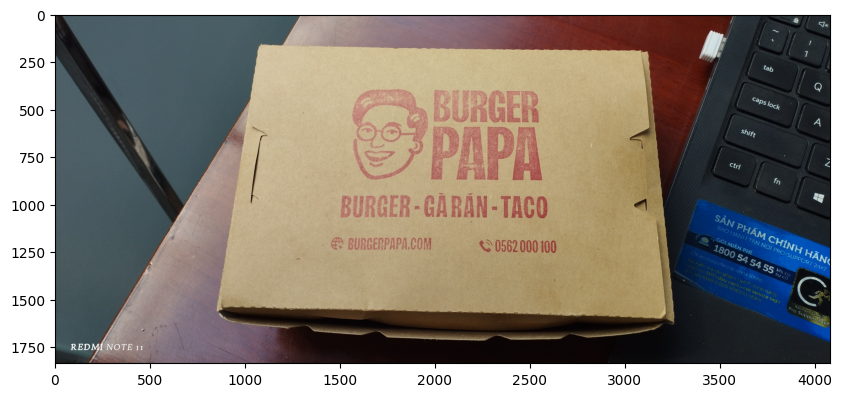

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: <image>
ở đây nhận giao hàng như thế nào ?
Assistant: ['sản phẩm chính hãng']


In [11]:
test_image = "/kaggle/input/testdataset-cv/data_test_cv/image/IMG_0.jpg"
plt.figure(figsize=(10,10))
plt.imshow(Image.open(test_image))
plt.show()
pixel_values = load_image(test_image, max_num=6).to(torch.bfloat16).cuda()
generation_config = dict(max_new_tokens= 512, do_sample=False, num_beams = 3, repetition_penalty=3.5)

question = '<image>\nở đây nhận giao hàng như thế nào ?'

response = model.chat(tokenizer, pixel_values, question, generation_config)
print(f'User: {question}\nAssistant: {response}')

In [12]:
response

"['sản phẩm chính hãng']"